<a href="https://colab.research.google.com/github/avaktrahu/experimental-jupyter-notebooks/blob/main/machine-learning/vectorization/chv/weighted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
import os
import torch
import pandas as pd

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [115]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import os

sns.set_theme(style="darkgrid")

# Set figure size and higher dpi
plt.rcParams['figure.dpi'] = 144

In [116]:
# %%shell
# rm -rf dataset avaktrahu_dataset

In [117]:
%%shell
if [ ! -d dataset ]; then
    mkdir -p dataset
    git clone https://github.com/avaktrahu/dataset.git avaktrahu_dataset
    cd avaktrahu_dataset/
    python -m pip install -r scripts/hf/requirements.txt
    python -m scripts.hf.pull
    mv dataset/ ../
fi

Cloning into 'avaktrahu_dataset'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 56 (delta 9), reused 51 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (56/56), 14.79 KiB | 14.79 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Attempting to pull dataset from repository: avaktrahu/dataset
Fetching 32 files:   0% 0/32 [00:00<?, ?it/s]
cmeoomzq8000602l919aq9ygx.md: 19.1kB [00:00, 11.6MB/s]

cmek60hms000402kv057ehknx.md: 5.54kB [00:00, 14.1MB/s]

cmewzkkzr000402icgvetd99g.md: 4.27kB [00:00, 7.93MB/s]

cmetkt2sh002102l1g62jhlte.md: 25.7kB [00:00, 12.7MB/s]

avaktrahu.hashnode.dev.meta.csv: 1.40kB [00:00, 5.33MB/s]

.gitattributes: 2.46kB [00:00, 4.34MB/s]
Fetching 32 files:   3% 1/32 [00:00<00:08,  3.49it/s]
cmeiz6t5f000002kvg8xshkur.md: 3.67kB [00:00, 13.8MB/s]

dataset.meta.csv: 100% 927/927 [00:00<00:00, 6.32MB/s]

cmekbf01t000302icc1bkhr3o.md: 6.69kB [00:00, 1.40MB/s]

Dock

In [118]:
%%shell
ls
ls dataset -lAR

avaktrahu_dataset  dataset  sample_data
dataset:
total 4
drwxr-xr-x 3 root root 4096 Aug 29 18:18 software

dataset/software:
total 4
drwxr-xr-x 3 root root 4096 Aug 29 18:18 code

dataset/software/code:
total 4
drwxr-xr-x 3 root root 4096 Aug 29 18:18 github

dataset/software/code/github:
total 4
drwxr-xr-x 6 root root 4096 Aug 29 18:18 avaktrahu

dataset/software/code/github/avaktrahu:
total 32
drwxr-xr-x 2 root root 4096 Aug 29 18:18 avaktrahu.hashnode.dev
-rw-r--r-- 1 root root 1403 Aug 29 18:18 avaktrahu.hashnode.dev.meta.csv
drwxr-xr-x 4 root root 4096 Aug 29 18:18 dataset
-rw-r--r-- 1 root root  927 Aug 29 18:18 dataset.meta.csv
drwxr-xr-x 3 root root 4096 Aug 29 18:18 experimental-jupyter-notebooks
-rw-r--r-- 1 root root  363 Aug 29 18:18 experimental-jupyter-notebooks.meta.csv
drwxr-xr-x 3 root root 4096 Aug 29 18:18 nsfw-prompts
-rw-r--r-- 1 root root  252 Aug 29 18:18 nsfw-prompts.meta.csv

dataset/software/code/github/avaktrahu/avaktrahu.hashnode.dev:
total 76
-rw-r--r-- 1 

In [119]:
class CHV(torch.nn.Module):
    """
    Character Vector model.
    """

    def __init__(self, charset_size: int, vector_size: int):
        """
        Initialize the CHV model.

        Args:
            charset_size (int): The size of the character vocabulary (C).
            vector_size (int): The desired dimension of the character embedding (K).
        """
        super(CHV, self).__init__()

        # Encoder layer
        self.encoder = torch.nn.Linear(
            in_features=charset_size,
            out_features=vector_size
        )

        # Magic layer
        self.activation = torch.nn.Tanh()

        # expansion layer
        self.expansion = torch.nn.Linear(
            in_features=vector_size,
            out_features=(vector_size + charset_size + 3) // 3,
        )

        # Another magic layer
        self.nonlinear = torch.nn.Tanh()

        # Takes the K-dimensional embedding and tries to reconstruct
        self.decoder = torch.nn.Linear(
            in_features=(vector_size + charset_size + 3) // 3,
            out_features=charset_size
        )

        # For probabilistic output
        # Not required with CorssEntropyLoss
        # self.normalized = torch.nn.Softmax(dim=-1)

    def encode(self, X: torch.Tensor) -> torch.Tensor:
        """
        Performs encoding through the CHV model.

        Args:
            X (torch.Tensor): Input tensor, typically a batch of one-hot ecoded
                              characters of shape (batch_size, charset_size).

        Returns:
            torch.Tensor: Encoded tensor of shape (batch_size, vector_size).
        """
        return self.activation(self.encoder(X))

    def decode(self, X: torch.Tensor) -> torch.Tensor:
        """
        Performs decoding through the CHV model.

        Args:
            X (torch.Tensor): Input tensor, typically a encoded vector
                              of shape (batch_size, vector_size).

        Returns:
            torch.Tensor: Decoded tensor of shape (batch_size, charset_size).
        """
        return self.decoder(self.nonlinear(self.expansion(X)))

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Performs a forward pass through the CHV model.

        Args:
            X (torch.Tensor): Input tensor, typically a batch of one-hot ecoded
                              characters of shape (batch_size, charset_size).

        Returns:
            torch.Tensor: Reconstructed output tensor of shape (batch_size, charset_size).
        """
        return self.decode(self.encode(X))

In [120]:
class FileDataset(Dataset):
    """
    A PyTorch Dataset for loading text content from files with specific extensions.
    """
    def __init__(self, dataset, ext=['.md', '.py', '.sh', '.csv']):
        """
        Initialize the FileDataset.

        Args:
            dataset_dir (str): The path to the directory containing the dataset.
            ext (list): A list of file extensions to include.
        """
        self.dataset_dir = dataset
        self.allowed_extensions = ext
        self.files = []

        self._discover_files()

    def _discover_files(self):
        """
        Collects paths of files with allowed extensions within the directory.
        """
        for root, _, files in os.walk(self.dataset_dir):
            for file in files:
                if any(file.endswith(ext) for ext in self.allowed_extensions):
                    self.files.append(os.path.join(root, file))

    def __len__(self):
        """
        Returns the total number of files in the dataset.
        """
        return len(self.files)

    def __getitem__(self, idx):
        """
        Loads and returns the content of a file at the given index.

        Args:
            idx (int): The index of the file to load.

        Returns:
            str: The content of the file.
        """
        file_path = self.files[idx]
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()
            return content
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
            return None

# Exploratory Data Analytics

In [121]:
dataset = FileDataset('dataset')

In [122]:
char_counts = {}
file_counts = {}

for i, content in enumerate(dataset):
    if content is not None:
        file_path = dataset.files[i]
        _, file_extension = os.path.splitext(file_path)

        if file_extension not in file_counts:
            file_counts[file_extension] = 0
        file_counts[file_extension] += 1

        char_count = len(content)
        if file_extension not in char_counts:
            char_counts[file_extension] = 0
        char_counts[file_extension] += char_count

display(file_counts)
display(char_counts)

{'.csv': 4, '.md': 10, '.sh': 4, '.py': 6}

{'.csv': 2669, '.md': 60290, '.sh': 4788, '.py': 15312}

In [123]:
df_counts = pd.DataFrame({
    'Extension': list(file_counts.keys()),
    'File Count': list(file_counts.values()),
    'Character Count': list(char_counts.values())
})

display(df_counts.head())

,Extension,File Count,Character Count
0,.csv,4,2669
1,.md,10,60290
2,.sh,4,4788
3,.py,6,15312


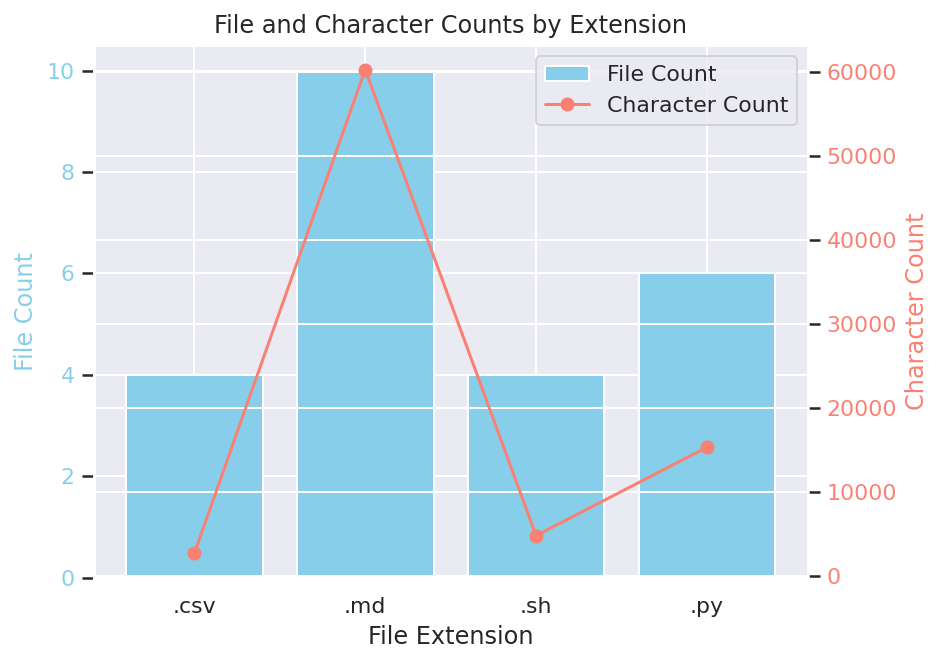

In [124]:
fig, ax1 = plt.subplots()

# Plotting File Count as bars
ax1.bar(df_counts['Extension'], df_counts['File Count'], color='skyblue', label='File Count')
ax1.set_xlabel('File Extension')
ax1.set_ylabel('File Count', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Creating a second y-axis for Character Count
ax2 = ax1.twinx()
ax2.plot(df_counts['Extension'], df_counts['Character Count'], color='salmon', marker='o', label='Character Count')
ax2.set_ylabel('Character Count', color='salmon')
ax2.tick_params(axis='y', labelcolor='salmon')

# Adding title and legends
plt.title('File and Character Counts by Extension')
fig.legend(bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()

# Training

In [125]:
# --- Global Charset Calculation and Frequency Counting ---
# Collect all characters from the entire dataset and count their frequencies
# Process dataset in an iterative manner to avoid loading the entire dataset into memory
char_counts = {}
total_chars = 0
for content in dataset:
    if content is not None:
        for char in content:
            char_counts[char] = char_counts.get(char, 0) + 1
            total_chars += 1

charset = sorted(list(char_counts.keys()))
charset_size = len(charset)
char_to_idx = {char: idx for idx, char in enumerate(charset)}

# Calculate inverse frequencies as weights (handle division by zero if any char has count 0, unlikely...)
char_weights = torch.zeros(charset_size)
for char, count in char_counts.items():
    if count > 0:
        char_weights[char_to_idx[char]] = 1.0 / count # Inverse frequency
    else:
        char_weights[char_to_idx[char]] = 0.0 # Assign 0 weight to characters with 0 count

# Normalize weights (optional, but can help with stability)
# char_weights = char_weights / char_weights.sum()

# ---------------------------------------------------------

print(f"Charset size: {charset_size}")
display(char_weights)

Charset size: 151


tensor([7.5758e-04, 7.8394e-05, 6.2500e-02, 2.5253e-03, 3.0675e-03, 2.3810e-02,
        4.5455e-02, 1.6667e-01, 5.7471e-03, 4.5045e-03, 4.5045e-03, 1.6287e-03,
        1.1111e-01, 1.9960e-03, 1.6502e-03, 1.4472e-03, 5.5866e-03, 4.8309e-03,
        6.6225e-03, 5.1020e-03, 1.0309e-02, 1.0989e-02, 9.5238e-03, 1.1494e-02,
        1.2500e-02, 1.0638e-02, 1.0753e-02, 2.3641e-03, 5.8824e-02, 2.5000e-01,
        4.7416e-04, 5.8824e-02, 5.5556e-02, 1.2500e-01, 3.1447e-03, 1.7241e-02,
        5.8824e-03, 6.1728e-03, 4.9261e-03, 1.4925e-02, 9.4340e-03, 1.1628e-02,
        4.7619e-03, 2.0000e-01, 3.3333e-01, 1.2346e-02, 7.6923e-03, 1.5625e-02,
        4.9751e-03, 7.0922e-03, 1.4286e-01, 6.2112e-03, 2.8653e-03, 2.3923e-03,
        1.3514e-02, 2.6316e-02, 2.4390e-02, 2.0000e-01, 4.5455e-02, 5.0000e-01,
        6.8493e-03, 1.0000e-01, 6.8493e-03, 1.0000e+00, 5.5556e-03, 4.3103e-03,
        2.3849e-04, 1.6667e-03, 4.3554e-04, 5.1099e-04, 1.6300e-04, 9.0909e-04,
        8.7719e-04, 6.2305e-04, 2.4624e-

In [126]:
def custom_collate_fn(batch, char_to_idx, charset_size, context_size=5):
    """
    Optimized custom collate function to handle variable-length text data for a bag-of-words approach.
    For each character in the text, the input is a vector mean of its surrounding context
    (excluding the character itself), and the target is the character's index.

    Args:
        batch (list): A list of text content strings from the dataset.
        char_to_idx (dict): A dictionary mapping characters to their indices.
        charset_size (int): The total size of the character set.
        context_size (int): The number of characters to consider on each side of the target character.

    Returns:
        tuple: A tuple containing batched inputs and targets.
    """
    all_batched_inputs = []
    all_batched_targets = []

    # Process each content string in the batch
    for content in batch:
        if content is None:
            continue

        # Convert the entire content string to a list of numerical indices.
        # Characters not found in `char_to_idx` are mapped to -1, which will be ignored later.
        content_indices = [char_to_idx.get(char, -1) for char in content]

        inputs_for_content = []
        targets_for_content = []

        # Iterate through each character and its corresponding index in the content
        for i, target_idx in enumerate(content_indices):
            # Only process if the current target character is known (its index is not -1)
            if target_idx == -1:
                continue

            # --- Targets ---
            # For each valid character, we generate two (input, target) pairs:
            # 1. (Target Char One-Hot, Target Char Index) -> "Token --> Token"
            # 2. (Context Mean One-Hot, Target Char Index) -> "Context --> Token"

            # --- Input for "Token --> Token" ---
            # Create a one-hot vector for the target character itself.
            token_vector = torch.zeros(charset_size, dtype=torch.float)
            token_vector[target_idx] = 1
            inputs_for_content.append(token_vector)
            targets_for_content.append(torch.tensor(target_idx, dtype=torch.long))

            # --- Input for "Context --> Token" ---
            # This involves averaging one-hot vectors of characters in the surrounding context.

            # Define the boundaries of the context window.
            # `start_idx_context` ensures we don't go before the beginning of the string.
            # `end_idx_context` ensures we don't go beyond the end of the string.
            start_idx_context = max(0, i - context_size)
            end_idx_context = min(len(content_indices), i + context_size + 1)

            context_chars_indices = []
            for k in range(start_idx_context, end_idx_context):
                # The target character itself should not be part of its own context.
                if k == i:
                    continue
                char_in_context_idx = content_indices[k]
                # Only include known characters (not -1) in the context sum.
                if char_in_context_idx != -1:
                    context_chars_indices.append(char_in_context_idx)

            # If there are valid characters in the context, compute their mean one-hot vector.
            if context_chars_indices:
                # Convert the list of context character indices into a PyTorch tensor.
                context_indices_tensor = torch.tensor(context_chars_indices, dtype=torch.long)
                # Generate one-hot vectors for all context characters simultaneously,
                # then average them up along the first dimension to get the bag-of-words context vector.
                context_vector = torch.mean(
                    torch.nn.functional.one_hot(context_indices_tensor, num_classes=charset_size).float(),
                    dim=0
                ).float()

                inputs_for_content.append(context_vector)
                targets_for_content.append(torch.tensor(target_idx, dtype=torch.long))
            else:
                # If no valid context characters, the context vector remains all zeros.
                # Ignore this case
                pass

        # After processing all characters in the current content string, add its generated
        # inputs and targets to the overall batch lists.
        if inputs_for_content:
            all_batched_inputs.extend(inputs_for_content)
            all_batched_targets.extend(targets_for_content)

    # After processing all content strings in the batch, stack all collected inputs and targets
    # into single PyTorch tensors.
    if all_batched_inputs:
        return torch.stack(all_batched_inputs), torch.stack(all_batched_targets)
    else:
        # If no valid data was found across the entire batch, return empty tensors
        # with appropriate shapes and data types to prevent errors in downstream processing.
        return torch.empty(0, charset_size, dtype=torch.float), torch.empty(0, dtype=torch.long)

In [127]:
def train_model(model, dataset, num_epochs, learning_rate, char_to_idx, charset_size, batch_size=32, context_size=5):
    """
    Helper function to train the CHV model using DataLoader and collate_fn,
    and record loss for each batch and epoch.

    Args:
        model (CHV): The CHV model to train.
        dataset (FileDataset): The dataset to train on.
        num_epochs (int): The number of training epochs.
        learning_rate (float): The learning rate for the optimizer.
        char_to_idx (dict): A dictionary mapping characters to their indices.
        charset_size (int): The total size of the character set.
        batch_size (int): The batch size for the DataLoader.
        context_size (int): The number of characters to consider on each side of the target character.

    Returns:
        tuple: A tuple containing lists of batch losses and epoch losses.
    """
    criterion = torch.nn.CrossEntropyLoss(weight=char_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda batch: custom_collate_fn(batch, char_to_idx, charset_size, context_size))

    batch_losses = []
    epoch_losses = []

    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0
        for inputs_batch, targets_batch in dataloader:
            if inputs_batch.numel() == 0: # Skip empty batches
                continue

            optimizer.zero_grad()
            outputs = model(inputs_batch)
            loss = criterion(outputs, targets_batch)
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())
            total_loss += loss.item()
            num_batches += 1

            print(f"\rEpoch [{epoch+1}/{num_epochs}:{num_batches}:{inputs_batch.shape}], Loss: {loss.item():.4f}", end='')

        epoch_loss = total_loss / num_batches if num_batches > 0 else 0
        epoch_losses.append(epoch_loss)
        print(f"\nEpoch [{epoch+1}/{num_epochs}] Average Loss: {epoch_loss:.4f}, Min Loss: {min(batch_losses[-num_batches:]):.4f}, Max Loss: {max(batch_losses[-num_batches:]):.4f}")

    return batch_losses, epoch_losses

In [128]:
vector_size = 6
model = CHV(charset_size, vector_size)

In [129]:
print(model)

CHV(
  (encoder): Linear(in_features=151, out_features=6, bias=True)
  (activation): Tanh()
  (expansion): Linear(in_features=6, out_features=53, bias=True)
  (nonlinear): Tanh()
  (decoder): Linear(in_features=53, out_features=151, bias=True)
)


In [130]:
batch_losses_0, epoch_losses_0 = train_model(model, dataset, num_epochs=40, learning_rate=0.06, char_to_idx=char_to_idx, charset_size=charset_size, batch_size=3, context_size=0)

Epoch [1/40:8:torch.Size([9728, 151])], Loss: 3.9283
Epoch [1/40] Average Loss: 4.8616, Min Loss: 3.9283, Max Loss: 5.5458
Epoch [2/40:8:torch.Size([2125, 151])], Loss: 1.0540
Epoch [2/40] Average Loss: 2.5654, Min Loss: 1.0540, Max Loss: 5.1968
Epoch [3/40:8:torch.Size([2521, 151])], Loss: 1.0111
Epoch [3/40] Average Loss: 1.2609, Min Loss: 0.2819, Max Loss: 4.0009
Epoch [4/40:8:torch.Size([30259, 151])], Loss: 0.2478
Epoch [4/40] Average Loss: 0.8342, Min Loss: 0.1706, Max Loss: 3.6581
Epoch [5/40:8:torch.Size([9239, 151])], Loss: 0.2664
Epoch [5/40] Average Loss: 0.6138, Min Loss: 0.1510, Max Loss: 3.2260
Epoch [6/40:8:torch.Size([30042, 151])], Loss: 0.0248
Epoch [6/40] Average Loss: 0.4343, Min Loss: 0.0248, Max Loss: 3.1105
Epoch [7/40:8:torch.Size([2572, 151])], Loss: 0.1459
Epoch [7/40] Average Loss: 0.2939, Min Loss: 0.0300, Max Loss: 1.4402
Epoch [8/40:8:torch.Size([37347, 151])], Loss: 0.9182
Epoch [8/40] Average Loss: 0.1671, Min Loss: 0.0214, Max Loss: 0.9182
Epoch [9/40:8

In [131]:
batch_losses_1_1, epoch_losses_1_1 = train_model(model, dataset, num_epochs=20, learning_rate=0.0006, char_to_idx=char_to_idx, charset_size=charset_size, batch_size=3, context_size=1)

Epoch [1/20:8:torch.Size([25938, 151])], Loss: 9.2440
Epoch [1/20] Average Loss: 10.4465, Min Loss: 9.2112, Max Loss: 11.7444
Epoch [2/20:8:torch.Size([26088, 151])], Loss: 10.5277
Epoch [2/20] Average Loss: 10.4350, Min Loss: 9.0854, Max Loss: 12.3903
Epoch [3/20:8:torch.Size([6252, 151])], Loss: 10.8355
Epoch [3/20] Average Loss: 10.3625, Min Loss: 9.1885, Max Loss: 11.0695
Epoch [4/20:8:torch.Size([13472, 151])], Loss: 11.2525
Epoch [4/20] Average Loss: 10.1593, Min Loss: 9.0584, Max Loss: 11.2525
Epoch [5/20:8:torch.Size([20118, 151])], Loss: 9.9845
Epoch [5/20] Average Loss: 10.0254, Min Loss: 8.8727, Max Loss: 11.0218
Epoch [6/20:8:torch.Size([26292, 151])], Loss: 8.7719
Epoch [6/20] Average Loss: 10.1664, Min Loss: 8.7719, Max Loss: 11.5785
Epoch [7/20:8:torch.Size([18888, 151])], Loss: 10.2573
Epoch [7/20] Average Loss: 9.9614, Min Loss: 8.7621, Max Loss: 10.8396
Epoch [8/20:8:torch.Size([60084, 151])], Loss: 10.1807
Epoch [8/20] Average Loss: 9.8616, Min Loss: 8.5741, Max Loss

In [132]:
batch_losses_1_2, epoch_losses_1_2 = train_model(model, dataset, num_epochs=10, learning_rate=0.006, char_to_idx=char_to_idx, charset_size=charset_size, batch_size=3, context_size=1)

Epoch [1/10:8:torch.Size([28386, 151])], Loss: 8.0139
Epoch [1/10] Average Loss: 8.6024, Min Loss: 7.9237, Max Loss: 9.7123
Epoch [2/10:8:torch.Size([17918, 151])], Loss: 6.7107
Epoch [2/10] Average Loss: 7.7974, Min Loss: 6.7107, Max Loss: 9.0845
Epoch [3/10:8:torch.Size([4144, 151])], Loss: 6.6000
Epoch [3/10] Average Loss: 7.0345, Min Loss: 6.3511, Max Loss: 7.8231
Epoch [4/10:8:torch.Size([11434, 151])], Loss: 6.5608
Epoch [4/10] Average Loss: 6.4946, Min Loss: 5.8118, Max Loss: 7.6149
Epoch [5/10:8:torch.Size([68384, 151])], Loss: 5.7157
Epoch [5/10] Average Loss: 5.9479, Min Loss: 5.3872, Max Loss: 6.7772
Epoch [6/10:8:torch.Size([28386, 151])], Loss: 4.9773
Epoch [6/10] Average Loss: 5.4841, Min Loss: 4.9773, Max Loss: 6.2693
Epoch [7/10:8:torch.Size([28366, 151])], Loss: 5.4020
Epoch [7/10] Average Loss: 4.8186, Min Loss: 3.9863, Max Loss: 5.4020
Epoch [8/10:8:torch.Size([25486, 151])], Loss: 4.2149
Epoch [8/10] Average Loss: 4.5814, Min Loss: 4.1504, Max Loss: 4.9011
Epoch [9/

In [133]:
batch_losses_3, epoch_losses_3 = train_model(model, dataset, num_epochs=20, learning_rate=0.006, char_to_idx=char_to_idx, charset_size=charset_size, batch_size=3, context_size=3)

Epoch [1/20:8:torch.Size([5702, 151])], Loss: 2.8478
Epoch [1/20] Average Loss: 3.5129, Min Loss: 2.8478, Max Loss: 3.9761
Epoch [2/20:8:torch.Size([3146, 151])], Loss: 2.7005
Epoch [2/20] Average Loss: 3.3239, Min Loss: 2.7005, Max Loss: 3.6401
Epoch [3/20:8:torch.Size([15620, 151])], Loss: 3.0025
Epoch [3/20] Average Loss: 3.1819, Min Loss: 2.7979, Max Loss: 3.8186
Epoch [4/20:8:torch.Size([69204, 151])], Loss: 2.9802
Epoch [4/20] Average Loss: 3.0555, Min Loss: 2.7095, Max Loss: 3.6099
Epoch [5/20:8:torch.Size([21562, 151])], Loss: 3.2877
Epoch [5/20] Average Loss: 2.9457, Min Loss: 2.5474, Max Loss: 3.2877
Epoch [6/20:8:torch.Size([22052, 151])], Loss: 2.9086
Epoch [6/20] Average Loss: 2.7980, Min Loss: 2.5516, Max Loss: 3.0444
Epoch [7/20:8:torch.Size([21232, 151])], Loss: 2.7703
Epoch [7/20] Average Loss: 2.7391, Min Loss: 2.3425, Max Loss: 2.9496
Epoch [8/20:8:torch.Size([2794, 151])], Loss: 2.2225
Epoch [8/20] Average Loss: 2.6078, Min Loss: 2.2225, Max Loss: 2.8610
Epoch [9/20

In [134]:
batch_losses_6, epoch_losses_6 = train_model(model, dataset, num_epochs=10, learning_rate=0.0006, char_to_idx=char_to_idx, charset_size=charset_size, batch_size=3, context_size=6)

Epoch [1/10:8:torch.Size([13906, 151])], Loss: 2.3700
Epoch [1/10] Average Loss: 2.2800, Min Loss: 2.0668, Max Loss: 2.4107
Epoch [2/10:8:torch.Size([58320, 151])], Loss: 2.4164
Epoch [2/10] Average Loss: 2.2600, Min Loss: 1.9693, Max Loss: 2.4164
Epoch [3/10:8:torch.Size([2682, 151])], Loss: 1.8044
Epoch [3/10] Average Loss: 2.1966, Min Loss: 1.8044, Max Loss: 2.3948
Epoch [4/10:8:torch.Size([13944, 151])], Loss: 2.4152
Epoch [4/10] Average Loss: 2.2231, Min Loss: 1.8270, Max Loss: 2.4152
Epoch [5/10:8:torch.Size([7326, 151])], Loss: 1.9735
Epoch [5/10] Average Loss: 2.2179, Min Loss: 1.9568, Max Loss: 2.4012
Epoch [6/10:8:torch.Size([8926, 151])], Loss: 2.1906
Epoch [6/10] Average Loss: 2.2364, Min Loss: 2.0815, Max Loss: 2.4046
Epoch [7/10:8:torch.Size([15510, 151])], Loss: 2.2310
Epoch [7/10] Average Loss: 2.1934, Min Loss: 2.0226, Max Loss: 2.3878
Epoch [8/10:8:torch.Size([26048, 151])], Loss: 2.3056
Epoch [8/10] Average Loss: 2.1923, Min Loss: 1.9349, Max Loss: 2.3789
Epoch [9/10

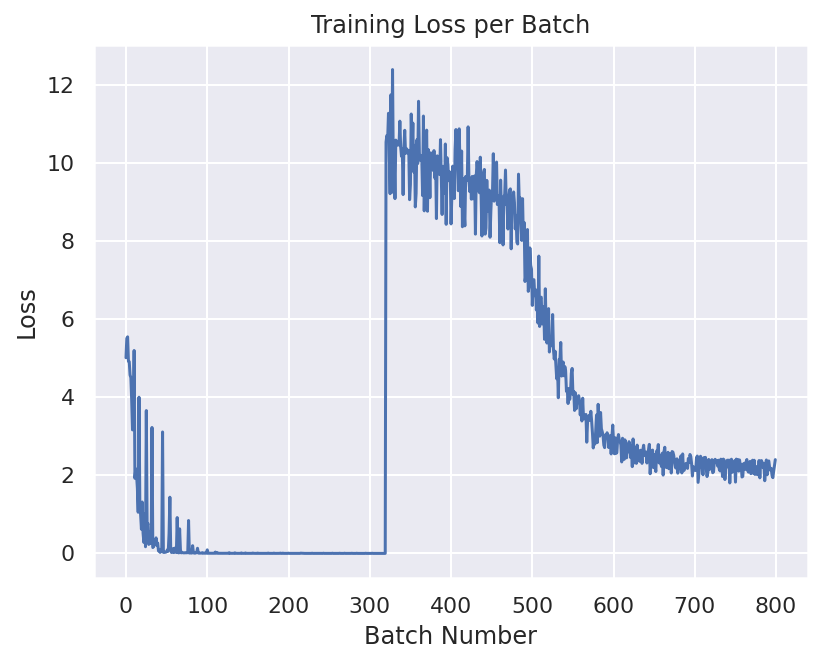

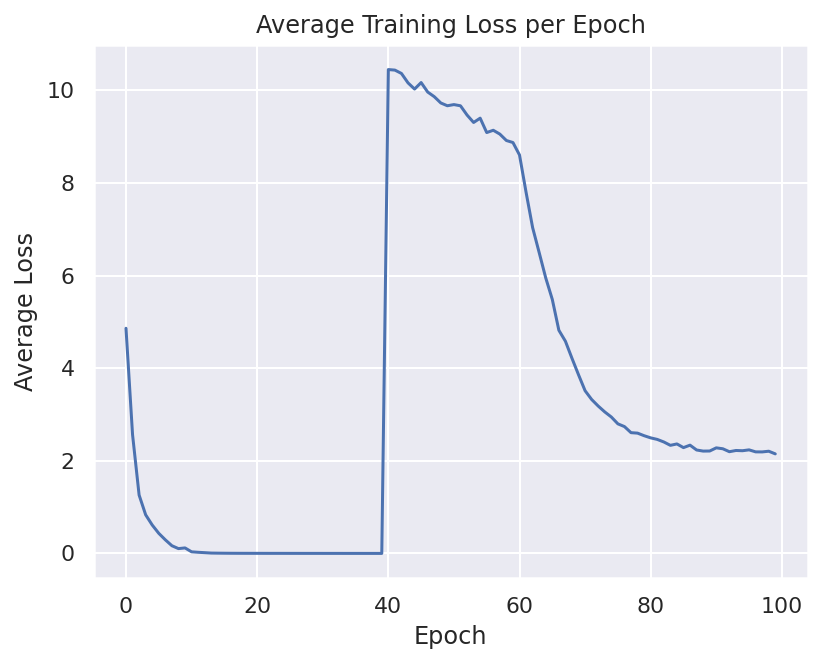

In [135]:
# Plotting batch losses
plt.figure()
plt.plot(batch_losses_0 + batch_losses_1_1 + batch_losses_1_2 + batch_losses_3 + batch_losses_6, label='Batch Loss')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.title('Training Loss per Batch')
plt.show()

# Plotting epoch losses
plt.figure()
plt.plot(epoch_losses_0 + epoch_losses_1_1 + epoch_losses_1_2 + epoch_losses_3 + epoch_losses_6, label='Epoch Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Average Training Loss per Epoch')
plt.show()

# Model Testing

In [136]:
def test_model(model, sentence, char_to_idx, charset_size):
    """
    Tests the CHV model with a given sentence.

    Args:
        model (CHV): The trained CHV model.
        sentence (str): The input sentence for testing.
        char_to_idx (dict): A dictionary mapping characters to their indices.
        charset_size (int): The total size of the character set.
    """
    model.eval() # Set the model to evaluation mode

    print(f"Input Sentence: '{sentence}'")
    print("\nCharacter Embeddings:")

    embeddings = []
    reconstructed_outputs = []
    reconstructed_chars = []

    idx_to_char = {idx: char for char, idx in char_to_idx.items()} # Create index to character mapping

    with torch.no_grad(): # Disable gradient calculation for inference
        softmax = torch.nn.Softmax(dim=-1) # For probabilistic output

        for char in sentence:
            if char in char_to_idx:
                # Create one-hot encoding for the character
                one_hot = torch.zeros(charset_size)
                one_hot[char_to_idx[char]] = 1
                input_tensor = one_hot.unsqueeze(0) # Add batch dimension

                # Get the embedding
                embedding = model.encode(input_tensor).squeeze(0)
                embeddings.append(embedding.numpy()) # Store as NumPy array

                # Get the reconstructed output (probabilities)
                reconstructed = softmax(model.decode(embedding.unsqueeze(0)))
                reconstructed_outputs.append(reconstructed.numpy()) # Store as NumPy array

                # Get the index of the most likely character
                predicted_idx = torch.argmax(reconstructed).item()
                reconstructed_char = idx_to_char.get(predicted_idx, '?') # Get character, use '?' for unknown
                reconstructed_chars.append(reconstructed_char)

                print(f"  Character '{char}': {embedding.tolist()}")
            else:
                print(f"  Character '{char}': Not in charset")
                reconstructed_chars.append('?') # Add '?' for unknown characters in reconstructed string

    print("\nEncode-Decode Output vs Original:")
    for i, char in enumerate(sentence):
        if char in char_to_idx:
            original_one_hot = torch.zeros(charset_size)
            original_one_hot[char_to_idx[char]] = 1
            original_output = original_one_hot.numpy()
            reconstructed_output = reconstructed_outputs[i]

            print(f"  Character '{char}':")
            print(f"    Original (One-Hot): {original_output.tolist()}")
            print(f"    Reconstructed (Probabilities): {reconstructed_output.tolist()}")
            print(f"    Reconstructed Character: '{reconstructed_chars[i]}'")

        else:
             print(f"  Character '{char}': Not in charset - Cannot compare")
             print(f"    Reconstructed Character: '{reconstructed_chars[i]}'")


    print(f"\nReconstructed Sentence: {''.join(reconstructed_chars)}")

In [137]:
test_model(model, 'Hello World! in Character Vector by Avaktrahu Shashthishalaka', char_to_idx, charset_size)

Input Sentence: 'Hello World! in Character Vector by Avaktrahu Shashthishalaka'

Character Embeddings:
  Character 'H': [-0.44968199729919434, 0.8726394176483154, -0.8522908091545105, -0.9225004315376282, 0.6314072608947754, 0.10458292812108994]
  Character 'e': [0.19060538709163666, 0.839051365852356, -0.8156472444534302, 0.5502103567123413, -0.876899003982544, 0.03653816878795624]
  Character 'l': [-0.9403387904167175, 0.49255526065826416, 0.7010848522186279, -0.4914282262325287, 0.4491487443447113, 0.8440012335777283]
  Character 'l': [-0.9403387904167175, 0.49255526065826416, 0.7010848522186279, -0.4914282262325287, 0.4491487443447113, 0.8440012335777283]
  Character 'o': [-0.4987872540950775, 0.6168307662010193, -0.5904440879821777, -0.5413317084312439, 0.2726934850215912, 0.8568729758262634]
  Character ' ': [-0.6204543113708496, 0.4309145212173462, -0.9419147372245789, -0.8553209900856018, -0.9673215746879578, 0.23932276666164398]
  Character 'W': [-0.05476858466863632, -0.51755

In [138]:
# Generate embeddings for all characters in the charset
all_char_embeddings = []
for char in charset:
    if char in char_to_idx:
        one_hot = torch.zeros(charset_size)
        one_hot[char_to_idx[char]] = 1
        input_tensor = one_hot.unsqueeze(0)
        embedding = model.encode(input_tensor).squeeze(0).detach().numpy() # Detach and convert to numpy
        all_char_embeddings.append(embedding)

# Convert embeddings to a pandas DataFrame for easier plotting
embeddings_df = pd.DataFrame(all_char_embeddings, index=charset)

embeddings_df.describe()

,0,1,2,3,4,5
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,-0.120465,0.103328,-0.050242,-0.060862,-0.090474,-0.010429
std,0.581882,0.544511,0.603965,0.577638,0.608967,0.569691
min,-0.987546,-0.929386,-0.976552,-0.973802,-0.997372,-0.978366
25%,-0.748450,-0.332830,-0.583204,-0.544302,-0.725164,-0.480790
50%,-0.054769,0.109153,-0.129591,-0.058836,0.022488,0.022282
75%,0.349128,0.544497,0.493107,0.443649,0.454046,0.481967
max,0.929317,0.982544,0.976126,0.961554,0.877242,0.961220


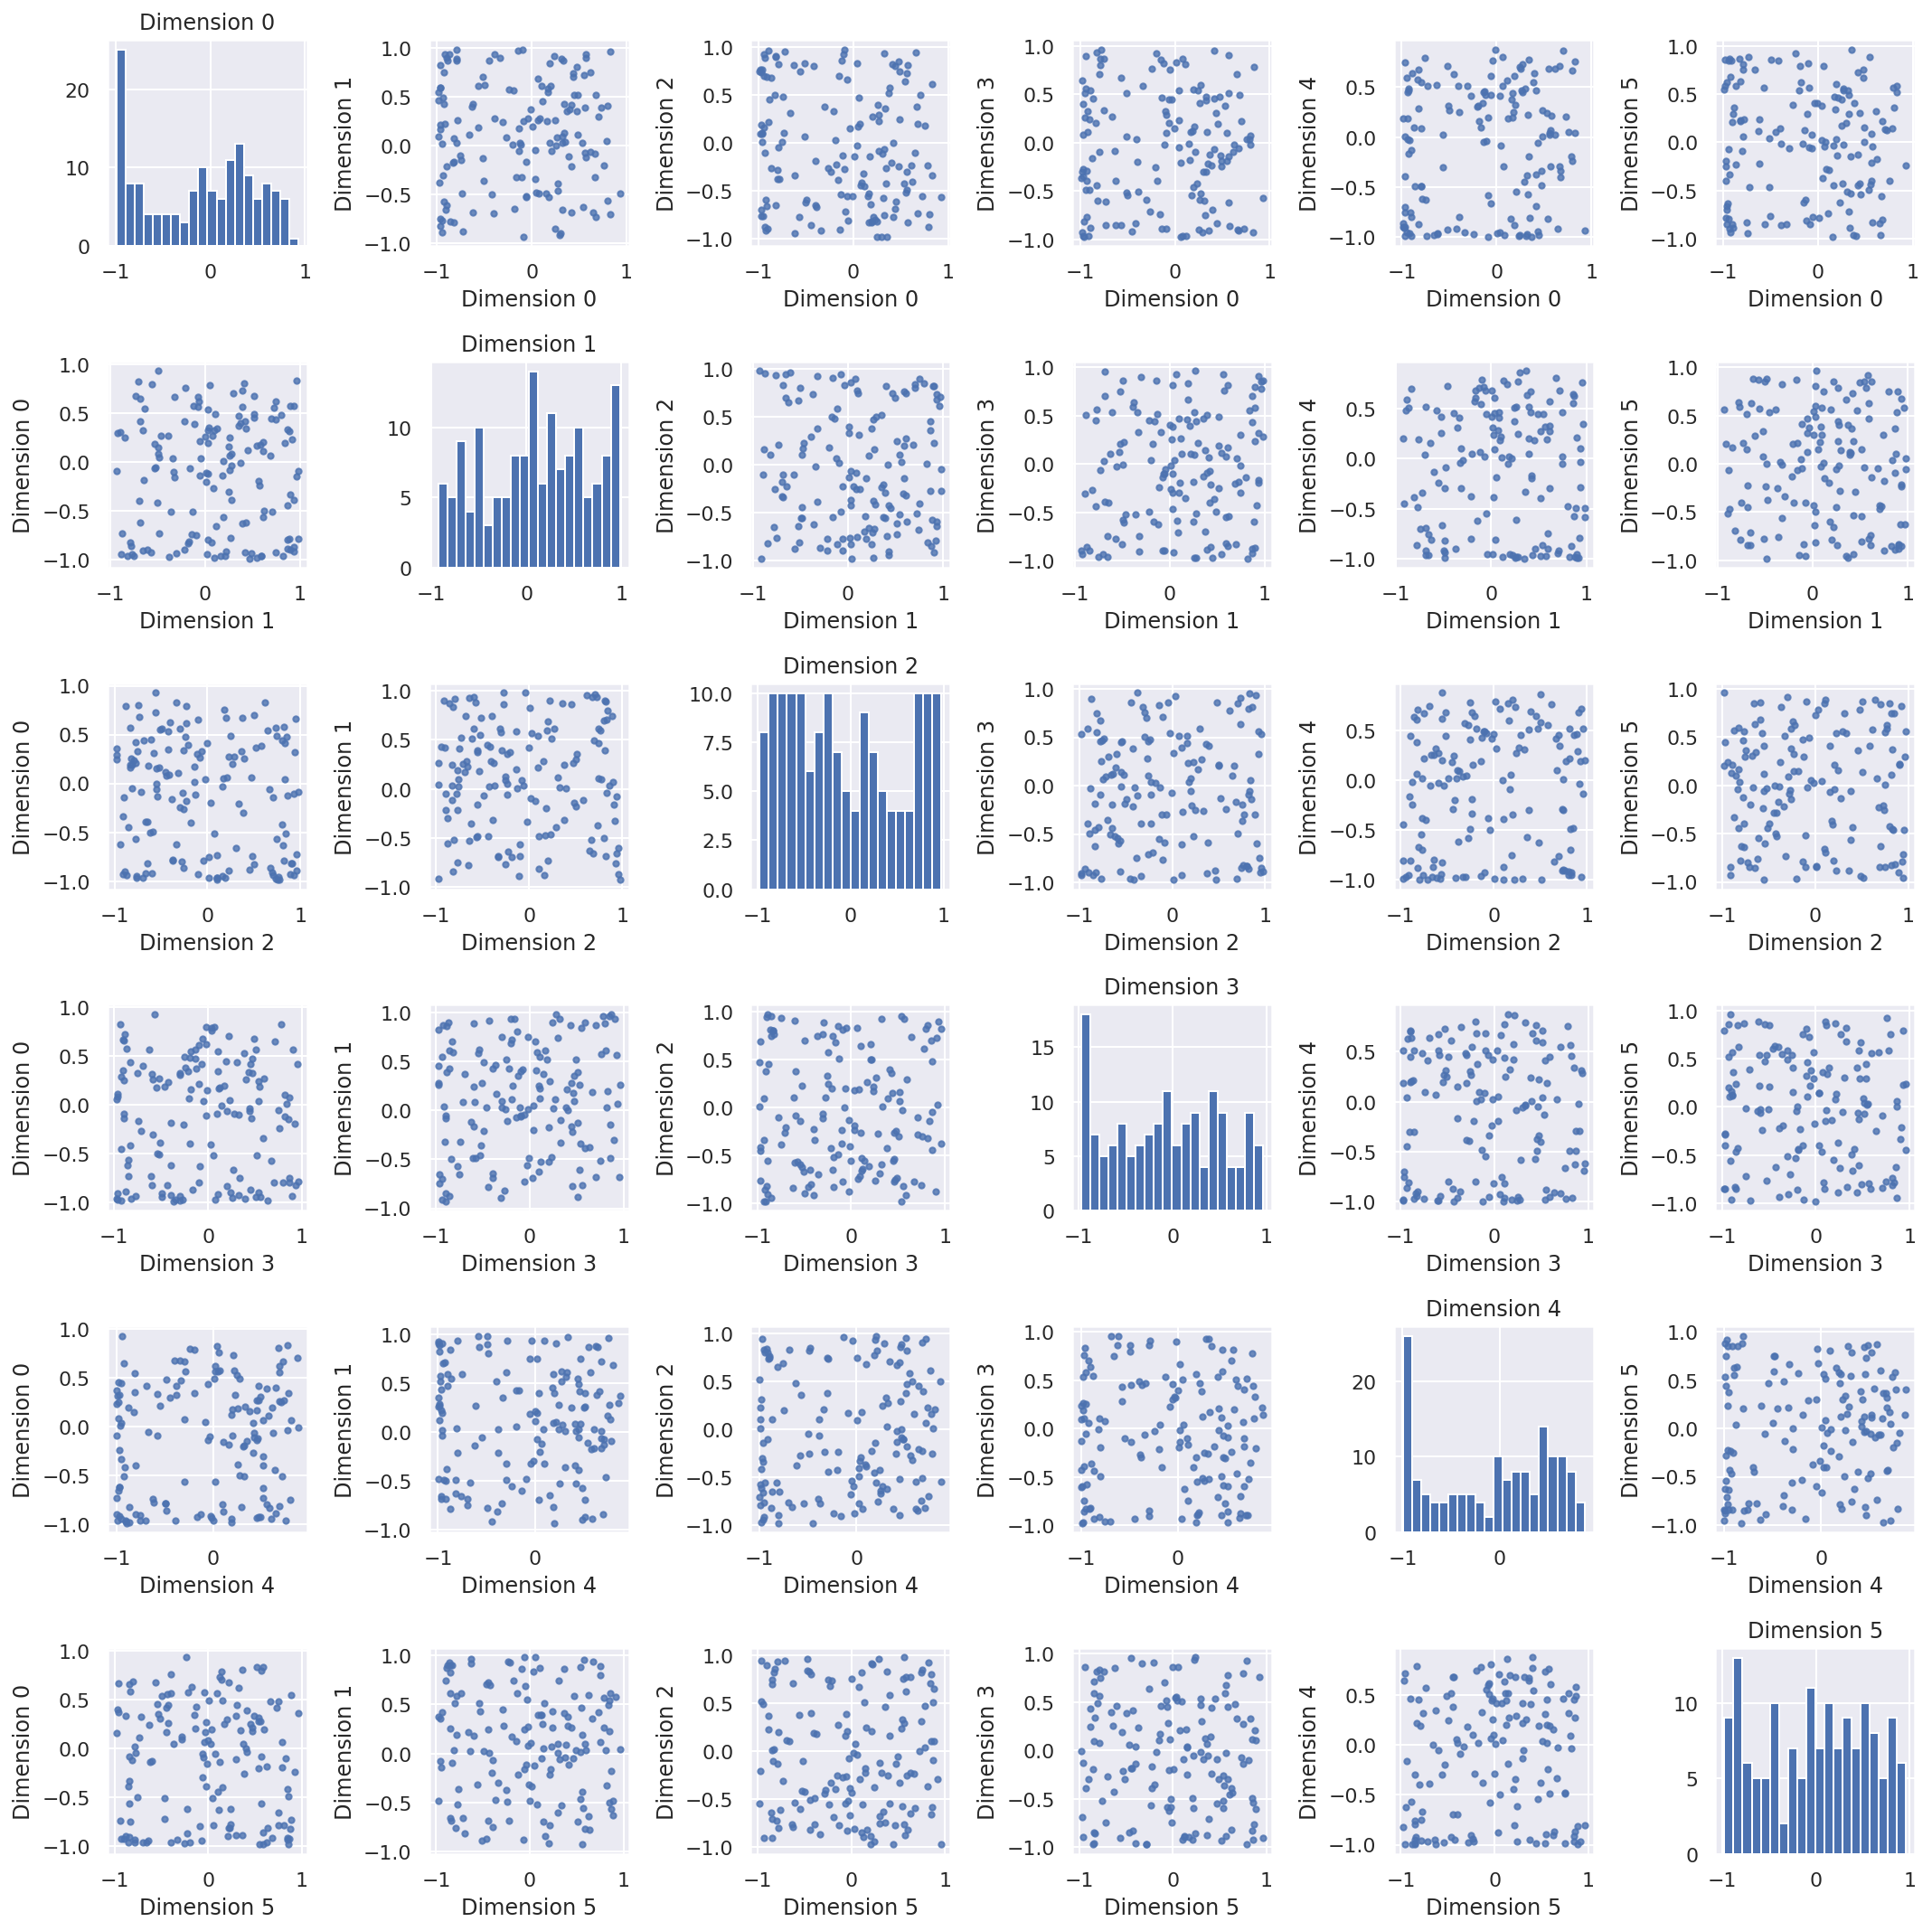

In [139]:
# Generate 2D scatter plots for all combinations of pairs of dimensions
num_dimensions = embeddings_df.shape[1]
fig, axes = plt.subplots(num_dimensions, num_dimensions, figsize=(15, 15))

for i in range(num_dimensions):
    for j in range(num_dimensions):
        if i == j:
            # Plot histogram on the diagonal
            embeddings_df[i].plot(kind='hist', bins=20, ax=axes[i, j])
            axes[i, j].set_title(f'Dimension {i}')
            axes[i, j].set_xlabel('')
            axes[i, j].set_ylabel('')
        else:
            # Plot scatter plot for off-diagonal
            embeddings_df.plot(kind='scatter', x=i, y=j, s=10, alpha=.8, ax=axes[i, j])
            axes[i, j].set_xlabel(f'Dimension {i}')
            axes[i, j].set_ylabel(f'Dimension {j}')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3202 (\N{KANNADA SIGN ANUSVARA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Kannada natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3205 (\N{KANNADA LETTER A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3206 (\N{KANNADA LETTER AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3207 (\N{KANNADA LETTER I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-

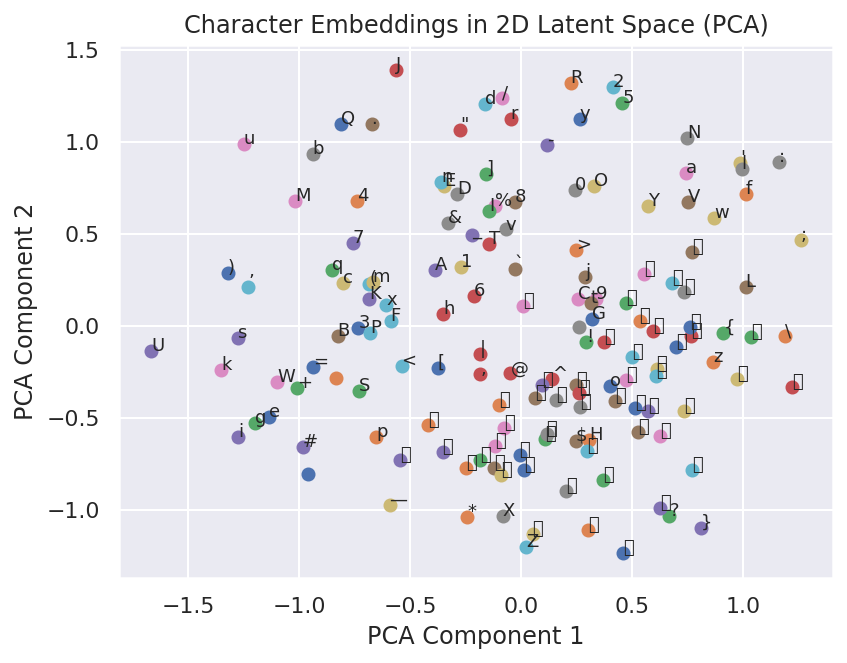

In [140]:
from sklearn.decomposition import PCA

# Perform PCA to reduce dimensionality to 2
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(all_char_embeddings)

# Create a 2D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot each character
for i, char in enumerate(charset):
    ax.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], marker='o')
    ax.text(embeddings_2d[i, 0], embeddings_2d[i, 1], char, fontsize=9)

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
plt.title('Character Embeddings in 2D Latent Space (PCA)')

plt.show()

In [141]:
def evaluate_charset_reconstruction(model, charset, char_to_idx, charset_size):
    """
    Evaluates how well the model reconstructs each character in the charset using batch processing.

    Args:
        model (CHV): The trained CHV model.
        charset (list): The list of all characters in the charset.
        char_to_idx (dict): A dictionary mapping characters to their indices.
        charset_size (int): The total size of the character set.

    Returns:
        tuple: A tuple containing lists of original indices and predicted indices.
    """
    model.eval()  # Set the model to evaluation mode
    idx_to_char = {idx: char for char, idx in char_to_idx.items()}
    softmax = torch.nn.Softmax(dim=-1)

    print("Evaluating Charset Reconstruction (Batched):")
    misreconstructed_chars = []
    original_indices = []
    predicted_indices = []

    with torch.no_grad():
        # Create a batch of one-hot encoded characters for the entire charset
        input_batch = torch.zeros(len(charset), charset_size)
        chars_in_batch = []


        for i, char in enumerate(charset):
            if char in char_to_idx:
                input_batch[i, char_to_idx[char]] = 1
                chars_in_batch.append(char)


        if input_batch.numel() == 0:
            print("No valid characters in the charset to evaluate.")
            return [], []

        # Get the embeddings and reconstructed outputs for the entire batch
        embeddings = model.encode(input_batch)
        reconstructed_outputs = softmax(model.decode(embeddings))

        # Get the predicted indices for the batch
        predicted_indices_batch = torch.argmax(reconstructed_outputs, dim=1).tolist()

        # Collect original and predicted indices and identify misreconstructed characters
        for i, original_char in enumerate(chars_in_batch):
             original_idx = char_to_idx[original_char]
             predicted_idx = predicted_indices_batch[i]
             original_indices.append(original_idx)
             predicted_indices.append(predicted_idx)

             reconstructed_char = idx_to_char.get(predicted_idx, '?')
             if original_char != reconstructed_char:
                 misreconstructed_chars.append(f"'{original_char}' (encoded to '{reconstructed_char}')")


    if misreconstructed_chars:
        print("\nCharacters not reconstructed properly:")
        for char_pair in misreconstructed_chars:
            print(char_pair)
    else:
        print("\nAll characters in the charset were reconstructed properly.")

    return original_indices, predicted_indices

original_indices, predicted_indices = evaluate_charset_reconstruction(model, charset, char_to_idx, charset_size)

Evaluating Charset Reconstruction (Batched):

All characters in the charset were reconstructed properly.


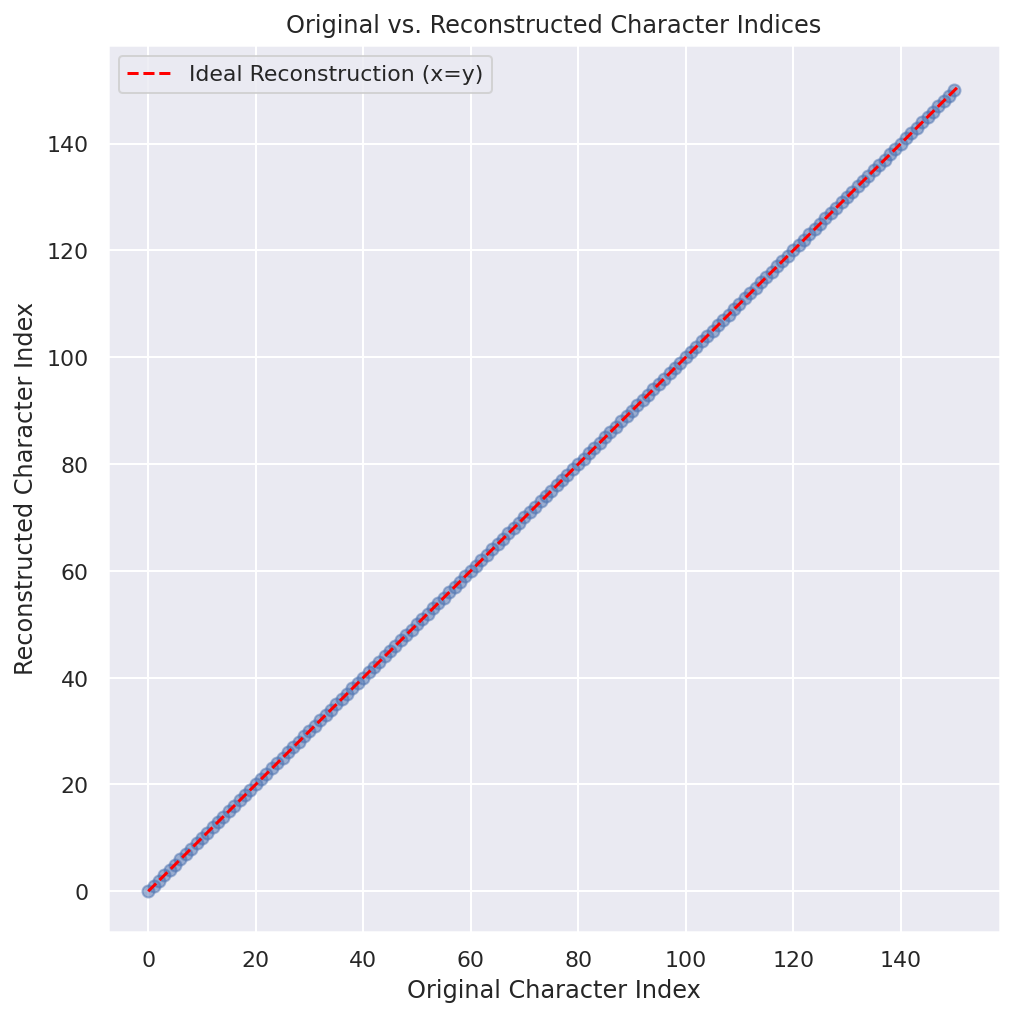

In [142]:
plt.figure(figsize=(8, 8))
plt.scatter(original_indices, predicted_indices, alpha=0.5)
plt.plot([0, charset_size], [0, charset_size], color='red', linestyle='--', label='Ideal Reconstruction (x=y)')
plt.xlabel('Original Character Index')
plt.ylabel('Reconstructed Character Index')
plt.title('Original vs. Reconstructed Character Indices')
plt.legend()
plt.grid(True)
plt.show()